# Model Training for Behaviour Classification

This notebook trains and saves the final shortlisted models for behaviour classification based on accelerometer data.  
From the accelerometer data, we train HydraROCKET on burst 1 uncorrected  
The [tsai environment](../environment_tsai.yml) is required to run this notebook.  

In [1]:
import os
import time
from datetime import datetime

import numpy as np
import pandas as pd
import torch

# For TSAI
import tsai.all as ts
from fastai.interpret import ClassificationInterpretation

In [2]:
def load_training_data(pq_file_path, target_col="attribution_merged"):
    """Load and preprocess accelerometer data from a parquet file with behaviour annotations.

    Args:
        pq_file_path (str): Path to the parquet file containing accelerometer data.
        target_col (str): Column name for behaviour classification (default: "attribution_merged").

    Returns:
        pd.DataFrame: Cleaned dataframe containing accelerometer data merged with annotations.
    """
    print(f"Loading data from: {pq_file_path}")

    # Load parquet file
    acc = pd.read_parquet(pq_file_path)

    # Load annotations
    annotations = pd.read_csv(
        "../data/temp/annotations/attributions_merged_majority_outliers.csv"
    )

    # Identify burst from parquet file name
    pq_file_name = os.path.basename(pq_file_path)
    burst = pq_file_name.split("_")[4]
    burst = "burst_" + burst
    print(f"Processing burst: {burst}")

    # Filter annotations for the current burst
    annotations = annotations[annotations["burst"] == burst]

    # Join annotations with accelerometer data
    acc = acc.merge(annotations, on=["Ind_ID", "new_burst"], how="left")

    # Remove other string columns except features, IDs, and target
    cols_to_keep = [target_col, "feature", "id", "Ind_ID", "new_burst"]
    string_cols = acc.select_dtypes(include="object").columns
    cols_to_drop = [col for col in string_cols if col not in cols_to_keep]
    acc = acc.drop(columns=cols_to_drop)

    # Remove rows with "Remove" value in target column
    remove_indices = acc[acc[target_col] == "Remove"].index
    acc = acc.drop(index=remove_indices)
    print(f"Removed {len(remove_indices)} rows with 'Remove' value")

    # Print class distribution
    class_dist = acc[target_col].value_counts()
    print(f"\nClass distribution:")
    for class_name, count in class_dist.items():
        print(f"  {class_name}: {count} ({count / len(acc) * 100:.1f}%)")

    return acc


# Test function
# pq_file_path = "../data/temp/acc_tsai/Burst_1/annotated_acc_tsai_burst_1_uncorrected.parquet"
# acc_data = load_training_data(pq_file_path)

In [3]:
def create_training_dsets(
    acc, random_seed, target_col="attribution_merged", valid_size=0.2
):
    """Create a TSDatasets object from a DataFrame for behaviour classification training.

    Args:
        acc (pd.DataFrame): DataFrame containing accelerometer data and labels.
        random_seed (int): Random seed for reproducible train/test splits.
        target_col (str): Column name containing the target labels.
        valid_size (float): Proportion of data for validation (default: 0.2).

    Returns:
        TSDatasets: A dataset object ready for use with tsai DataLoaders.
    """
    print("Formatting into tsai datasets")

    # Convert to TSAI format
    X, y = ts.df2xy(
        acc.drop(columns=["new_burst", "Ind_ID"]),  # Drop metadata columns
        sample_col="id",
        feat_col="feature",
        target_col=target_col,
        data_cols=None,
    )

    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")

    # Split into train and validation
    splits = ts.get_splits(
        y,
        valid_size=valid_size,
        stratify=True,
        random_state=random_seed,
        shuffle=True,
        show_plot=False,
    )

    print(f"Train samples: {len(splits[0])}")
    print(f"Validation samples: {len(splits[1])}")

    # Label processing function
    def y_func(o):
        """Convert labels to string format for multiclass classification."""
        labels = o[:, 0].astype("<U20")
        return labels

    # Convert X to float
    X_mod = X.astype(np.float64)

    # Create datasets for use with dataloaders
    tfms = [None, [ts.Categorize()]]
    dsets = ts.TSDatasets(X_mod, y=y_func(y), tfms=tfms, splits=splits, inplace=True)

    return dsets


# Test function
# dsets = create_training_dsets(acc_data, random_seed=42)

In [4]:
def train_hydrarocket_model(dsets, epochs=50, bs_train=64, bs_valid=128):
    """Train a HydraROCKET model for behaviour classification.

    Args:
        dsets: TSDatasets object with train/validation splits
        epochs (int): Number of training epochs (default: 50)
        bs_train (int): Training batch size (default: 64)
        bs_valid (int): Validation batch size (default: 128)

    Returns:
        tuple: (learner, training_time, metrics)
    """
    print("Training HydraROCKET model...")

    # Create dataloaders
    dls = ts.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs_train, bs_valid])

    # Determine if binary or multiclass
    is_binary = len(dls.vocab) == 2

    # Set up metrics
    roc_metric = ts.RocAucBinary() if is_binary else ts.RocAuc()
    metrics = [
        ts.accuracy,
        roc_metric,
        ts.BalancedAccuracy(),
        ts.F1Score(average="weighted"),
        ts.Precision(average="weighted"),
        ts.Recall(average="weighted"),
    ]

    # Create HydraROCKET model
    model = ts.create_model(ts.HydraMultiRocket, dls=dls)
    model = model.cuda()

    # Create learner
    learn = ts.Learner(dls, model, metrics=metrics)

    # Find optimal learning rate
    lr_max = learn.lr_find()

    # Train model
    start_time = time.time()

    learn.fit_one_cycle(epochs, lr_max)

    training_time = time.time() - start_time
    print(
        f"Training completed in {training_time:.1f} seconds ({training_time / 60:.1f} minutes)"
    )

    # Get final metrics
    final_vals = learn.recorder.values[-1]
    metrics_dict = {
        "train_loss": final_vals[0],
        "valid_loss": final_vals[1],
        "accuracy": final_vals[2],
        "roc_auc": final_vals[3],
        "balanced_acc": final_vals[4],
        "f1_score": final_vals[5],
        "precision": final_vals[6],
        "recall": final_vals[7],
        "training_time_seconds": training_time,
        "epochs": epochs,
        "lr_max": lr_max.valley,
    }

    print(f"\nFinal Training Metrics:")
    for metric, value in metrics_dict.items():
        if metric not in ["training_time_seconds", "epochs"]:
            print(f"  {metric}: {value:.4f}")

    return learn, training_time, metrics_dict

In [5]:
def evaluate_model_performance(learn, dsets):
    """Evaluate trained model and generate detailed performance metrics.

    Args:
        learn: Trained fastai learner
        dsets: TSDatasets object with class information

    Returns:
        tuple: (confusion_matrix_df, per_class_metrics_df)
    """
    print("Evaluating model performance...")

    # Generate predictions and confusion matrix
    interp = ClassificationInterpretation.from_learner(learn)
    conf_matrix = interp.confusion_matrix()
    classes = dsets.vocab

    # Create confusion matrix dataframe
    confusion_data = []
    for actual_idx, actual in enumerate(classes):
        for pred_idx, predicted in enumerate(classes):
            confusion_data.append(
                {
                    "actual_label": actual,
                    "predicted_label": predicted,
                    "count": int(conf_matrix[actual_idx, pred_idx]),
                }
            )

    confusion_df = pd.DataFrame(confusion_data)

    # Calculate per-class precision, recall, and F1
    per_class_metrics = []
    for i, class_name in enumerate(classes):
        # True positives, false positives, false negatives
        tp = conf_matrix[i, i]
        fp = conf_matrix[:, i].sum() - tp
        fn = conf_matrix[i, :].sum() - tp

        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = (
            2 * (precision * recall) / (precision + recall)
            if (precision + recall) > 0
            else 0
        )

        # Support (actual occurrences)
        support = conf_matrix[i, :].sum()

        per_class_metrics.append(
            {
                "class": class_name,
                "precision": float(precision),
                "recall": float(recall),
                "f1_score": float(f1),
                "support": int(support),
            }
        )

    per_class_df = pd.DataFrame(per_class_metrics)

    print("\nPer-class Performance:")
    print(per_class_df.round(4))

    return confusion_df, per_class_df


def save_model_and_metadata(
    learn,
    dsets,
    metrics_dict,
    confusion_df,
    per_class_df,
    model_dir="../models",
    model_name="hydrarocket_burst1_uncorrected",
):
    """Save trained model and associated metadata.

    Args:
        learn: Trained fastai learner
        dsets: TSDatasets object with class information
        metrics_dict: Dictionary of training metrics
        confusion_df: Confusion matrix dataframe
        per_class_df: Per-class metrics dataframe
        model_dir: Directory to save model files
        model_name: Base name for model files
    """
    print(f"Saving model and metadata to {model_dir}")

    # Create model directory if it doesn't exist
    os.makedirs(model_dir, exist_ok=True)

    # Save the trained model
    # model_path = os.path.join(model_dir, f"{model_name}.pkl")
    # learn.export(model_path)
    learn.save_all(
        path=model_dir,
        dls_fname=f"{model_name}_dls",
        model_fname=f"{model_name}_model",
        learner_fname=f"{model_name}_learner",
    )
    # print(f"Model saved to: {model_path}")

    # Create training metadata
    training_metadata = {
        "model_name": model_name,
        "model_type": "HydraROCKET",
        "training_date": datetime.now().isoformat(),
        "num_classes": len(dsets.vocab),
        "class_names": list(dsets.vocab),
        "train_samples": len(dsets.train),
        "valid_samples": len(dsets.valid),
        **metrics_dict,
    }

    # Save training metadata as CSV
    metadata_df = pd.DataFrame([training_metadata])
    metadata_path = os.path.join(model_dir, f"{model_name}_training_metadata.csv")
    metadata_df.to_csv(metadata_path, index=False)
    print(f"Training metadata saved to: {metadata_path}")

    # Save class mapping
    class_mapping = pd.DataFrame(
        {"class_index": range(len(dsets.vocab)), "class_name": list(dsets.vocab)}
    )
    class_mapping_path = os.path.join(model_dir, f"{model_name}_class_mapping.csv")
    class_mapping.to_csv(class_mapping_path, index=False)
    print(f"Class mapping saved to: {class_mapping_path}")

    # Save confusion matrix
    confusion_path = os.path.join(model_dir, f"{model_name}_confusion_matrix.csv")
    confusion_df.to_csv(confusion_path, index=False)
    print(f"Confusion matrix saved to: {confusion_path}")

    # Save per-class metrics
    per_class_path = os.path.join(model_dir, f"{model_name}_per_class_metrics.csv")
    per_class_df.to_csv(per_class_path, index=False)
    print(f"Per-class metrics saved to: {per_class_path}")

    return {
        # "model_path": model_path,
        "metadata_path": metadata_path,
        "class_mapping_path": class_mapping_path,
        "confusion_path": confusion_path,
        "per_class_path": per_class_path,
    }

## HydraROCKET - Burst 1 - Uncorrected

In [6]:
# Configuration Parameters
CONFIG_B1_UNC = {
    # Data paths
    "data_path": "../data/temp/acc_tsai/Burst_1/annotated_acc_tsai_burst_1_uncorrected.parquet",
    "model_dir": "../models/hr_b1_unc/",
    # Training parameters
    "random_seed": 42,
    "valid_size": 0.2,
    "epochs": 50,
    "batch_size_train": 64,
    "batch_size_valid": 128,
    # Target configuration
    "target_column": "attribution_merged",
    "model_name": "hr_b1_unc",
}

print("Configuration:")
for key, value in CONFIG_B1_UNC.items():
    print(f"  {key}: {value}")

# Set random seed for reproducibility
torch.manual_seed(CONFIG_B1_UNC["random_seed"])
np.random.seed(CONFIG_B1_UNC["random_seed"])
print(f"\nRandom seed set to: {CONFIG_B1_UNC['random_seed']}")

Configuration:
  data_path: ../data/temp/acc_tsai/Burst_1/annotated_acc_tsai_burst_1_uncorrected.parquet
  model_dir: ../models/hr_b1_unc/
  random_seed: 42
  valid_size: 0.2
  epochs: 50
  batch_size_train: 64
  batch_size_valid: 128
  target_column: attribution_merged
  model_name: hr_b1_unc

Random seed set to: 42


Loading data from: ../data/temp/acc_tsai/Burst_1/annotated_acc_tsai_burst_1_uncorrected.parquet
Processing burst: burst_1
Removed 822 rows with 'Remove' value

Class distribution:
  Resting: 1173 (37.2%)
  Eating: 1002 (31.7%)
  Walking: 366 (11.6%)
  Grooming actor: 285 (9.0%)
  Grooming receiver: 213 (6.7%)
  Sleeping: 78 (2.5%)
  Self-scratching: 24 (0.8%)
  Running: 15 (0.5%)
Formatting into tsai datasets
X shape: (1052, 3, 138)
y shape: (1052, 3)
Train samples: 842
Validation samples: 210
Training HydraROCKET model...


epoch,train_loss,valid_loss,accuracy,roc_auc_score,balanced_accuracy_score,f1_score,precision_score,recall_score,time
0,1.998711,1.990453,0.404762,0.863178,0.262567,0.321338,0.291011,0.404762,00:00
1,1.896860,1.817580,0.519048,0.884031,0.311531,0.489709,0.560869,0.519048,00:00
2,1.771853,1.590089,0.595238,0.814617,0.337776,0.569741,0.568749,0.595238,00:00
3,1.631368,1.364972,0.619048,0.819014,0.317621,0.593809,0.572578,0.619048,00:00
4,1.484905,1.186334,0.638095,0.919425,0.299864,0.596088,0.565934,0.638095,00:00
5,1.347829,1.063878,0.661905,0.925762,0.392984,0.637197,0.638968,0.661905,00:00
6,1.227106,1.013257,0.671429,0.928543,0.373393,0.637039,0.636118,0.671429,00:00
7,1.120361,0.987067,0.657143,0.930299,0.358295,0.627796,0.623995,0.657143,00:00
8,1.027740,0.976553,0.652381,0.931690,0.369009,0.621506,0.632207,0.652381,00:00
9,0.945921,0.971317,0.642857,0.930723,0.349355,0.616309,0.617544,0.642857,00:00


Training completed in 45.4 seconds (0.8 minutes)

Final Training Metrics:
  train_loss: 0.1704
  valid_loss: 0.8354
  accuracy: 0.7000
  roc_auc: 0.9446
  balanced_acc: 0.4425
  f1_score: 0.6888
  precision: 0.6961
  recall: 0.7000
  lr_max: 0.0000
Evaluating model performance...



Per-class Performance:
               class  precision  recall  f1_score  support
0             Eating     0.6875  0.8209    0.7483       67
1     Grooming actor     0.6250  0.5263    0.5714       19
2  Grooming receiver     0.5000  0.2143    0.3000       14
3            Resting     0.7381  0.7949    0.7654       78
4            Running     0.0000  0.0000    0.0000        1
5    Self-scratching     0.0000  0.0000    0.0000        2
6           Sleeping     1.0000  0.6000    0.7500        5
7            Walking     0.7778  0.5833    0.6667       24
Saving model and metadata to ../models/hr_b1_unc/
Training metadata saved to: ../models/hr_b1_unc/hr_b1_unc_training_metadata.csv
Class mapping saved to: ../models/hr_b1_unc/hr_b1_unc_class_mapping.csv
Confusion matrix saved to: ../models/hr_b1_unc/hr_b1_unc_confusion_matrix.csv
Per-class metrics saved to: ../models/hr_b1_unc/hr_b1_unc_per_class_metrics.csv


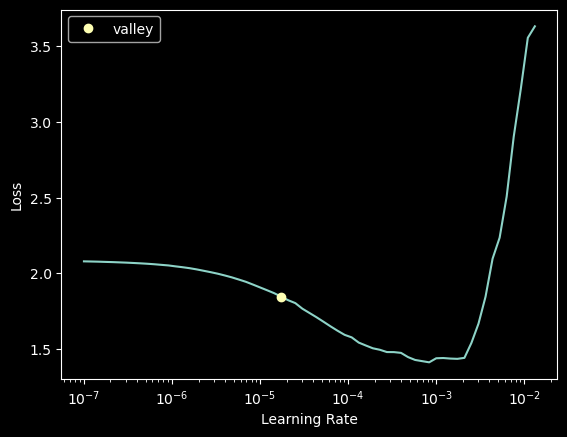

In [7]:
# Load acc and combine annotations
acc_data = load_training_data(
    CONFIG_B1_UNC["data_path"], target_col=CONFIG_B1_UNC["target_column"]
)

# Create training datasets
dsets = create_training_dsets(
    acc_data,
    random_seed=CONFIG_B1_UNC["random_seed"],
    target_col=CONFIG_B1_UNC["target_column"],
    valid_size=CONFIG_B1_UNC["valid_size"],
)

# Train HydraROCKET model
learn, training_time, metrics_dict = train_hydrarocket_model(
    dsets,
    epochs=CONFIG_B1_UNC["epochs"],
    bs_train=CONFIG_B1_UNC["batch_size_train"],
    bs_valid=CONFIG_B1_UNC["batch_size_valid"],
)

# Performance check
confusion_df, per_class_df = evaluate_model_performance(learn, dsets)

# Save model and metadata
model_metadata = save_model_and_metadata(
    learn,
    dsets,
    metrics_dict,
    confusion_df,
    per_class_df,
    model_dir=CONFIG_B1_UNC["model_dir"],
    model_name=CONFIG_B1_UNC["model_name"],
)

In [8]:
# Verify that everything is on the GPU
for name, module in learn.model.named_modules():
    if hasattr(module, "device"):
        print(f"Module: {name}, device attribute: {module.device}")
    else:
        # Optionally, check the device of module parameters
        params = list(module.parameters())
        if params:
            print(f"Module: {name}, parameter device: {params[0].device}")

for name, param in learn.model.named_parameters():
    print(f"{name}: {param.device}")

for name, buf in learn.model.named_buffers():
    print(f"{name}: {buf.device}")

Module: , parameter device: cuda:0
Module: backbone, parameter device: cuda:0
Module: backbone.hydra, device attribute: cuda:0
Module: backbone.multirocket, parameter device: cuda:0
Module: backbone.multirocket.branch_x, parameter device: cuda:0
Module: backbone.multirocket.branch_x_diff, parameter device: cuda:0
Module: head, parameter device: cuda:0
Module: head.1, parameter device: cuda:0
Module: head.2, parameter device: cuda:0
backbone.multirocket.branch_x.kernels: cuda:0
backbone.multirocket.branch_x_diff.kernels: cuda:0
head.1.weight: cuda:0
head.1.bias: cuda:0
head.2.weight: cuda:0
head.2.bias: cuda:0
backbone.multirocket.branch_x.channel_combinations_0: cuda:0
backbone.multirocket.branch_x.channel_combinations_1: cuda:0
backbone.multirocket.branch_x.channel_combinations_2: cuda:0
backbone.multirocket.branch_x.channel_combinations_3: cuda:0
backbone.multirocket.branch_x.channel_combinations_4: cuda:0
backbone.multirocket.branch_x.channel_combinations_5: cuda:0
backbone.multiroc

In [9]:
# Load model to check if it works
hr_b1_unc = ts.load_learner_all(
    path=CONFIG_B1_UNC["model_dir"],
    dls_fname=f"{CONFIG_B1_UNC['model_name']}_dls",
    model_fname=f"{CONFIG_B1_UNC['model_name']}_model",
    learner_fname=f"{CONFIG_B1_UNC['model_name']}_learner",
)

In [10]:
# Verify that everything is on the GPU
for name, module in hr_b1_unc.model.named_modules():
    if hasattr(module, "device"):
        print(f"Module: {name}, device attribute: {module.device}")
    else:
        # Optionally, check the device of module parameters
        params = list(module.parameters())
        if params:
            print(f"Module: {name}, parameter device: {params[0].device}")

for name, param in hr_b1_unc.model.named_parameters():
    print(f"{name}: {param.device}")

for name, buf in hr_b1_unc.model.named_buffers():
    print(f"{name}: {buf.device}")

Module: , parameter device: cuda:0
Module: backbone, parameter device: cuda:0
Module: backbone.hydra, device attribute: cuda:0
Module: backbone.multirocket, parameter device: cuda:0
Module: backbone.multirocket.branch_x, parameter device: cuda:0
Module: backbone.multirocket.branch_x_diff, parameter device: cuda:0
Module: head, parameter device: cuda:0
Module: head.1, parameter device: cuda:0
Module: head.2, parameter device: cuda:0
backbone.multirocket.branch_x.kernels: cuda:0
backbone.multirocket.branch_x_diff.kernels: cuda:0
head.1.weight: cuda:0
head.1.bias: cuda:0
head.2.weight: cuda:0
head.2.bias: cuda:0
backbone.multirocket.branch_x.channel_combinations_0: cuda:0
backbone.multirocket.branch_x.channel_combinations_1: cuda:0
backbone.multirocket.branch_x.channel_combinations_2: cuda:0
backbone.multirocket.branch_x.channel_combinations_3: cuda:0
backbone.multirocket.branch_x.channel_combinations_4: cuda:0
backbone.multirocket.branch_x.channel_combinations_5: cuda:0
backbone.multiroc